# Class Weight Calculator

This notebook allows you to load data in and calculate the necessary class weights 
needed to put in the config.yaml file.

In [150]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yaml

### Load in the data.

Here we have the data as a CSV file, but you may need to change that for your data
formatting.

In [151]:
def get_counts(file, allowed_types):
    """
    Generates counts of objects using the data (here a CSV file) in ./data
    """
    df = pd.read_csv(file)
    print(df.head())
    counts = df[df['type'].isin(allowed_types)]['type'].value_counts()
    total_sum = counts.sum()
    return counts, total_sum

In [152]:
vertices = ['SLSN-I', 'SLSN-II', 'SN', 'SN II', 'SN II-pec', 'SN IIb', 'SN IIn', 
            'SN Ia', 'SN Ia-91T','SN Ia-91bg-like', 'SN Ia-CSM' ,'SN Ia-SC', 
            'SN Ia-pec' ,'SN Iax', 'SN Ib', 'SN Ib-pec', 'SN Ib/c', 'SN Ibn', 
            'SN Ic' ,'SN Ic-BL', 'SN Ic-Ca-rich', 'SN Ic-pec', 'SN Icn', 
            'TDE', 'SN-like', 'CC', 'SN II-gen', 'SN-gen', 'SN Ia-gen', 'SN II-like', 
            'SN Ib/c-gen', 'SN Ic-gen', 'SN Ib-gen']
counts, total = get_counts('./data/tns_public_objects.csv', vertices)
counts, total

  name_prefix     name                                internal_names  \
0          SN  2025nbz                         ZTF25aaufdhw, PS25dft   
1          SN  2025mbd  PS25cxw, GOTO25den, ATLAS25ftu, ZTF25aasltmi   
2          AT  2025nzw                                     GOTO25drt   
3          SN  2025ngg           ZTF25aauijjd, ATLAS25gbr, GOTO25dnt   
4          AT  2025nni                      ATLAS25gcx, ZTF25aauczue   

           ra  declination  redshift    type  
0  332.967542     0.110692  0.033000   SN II  
1  256.867203    34.567511  0.027000  SN IIn  
2  320.206233     8.685154       NaN     NaN  
3  242.716125   -24.974943  0.025438   SN Ia  
4  247.208186    20.547384       NaN     NaN  


(type
 SN Ia              11081
 SN II               2658
 SN IIn               479
 SN Ic                367
 SN Ib                300
 SN IIb               258
 SLSN-I               185
 SN Ic-BL             159
 SN Ia-91bg-like      154
 TDE                  106
 SLSN-II              103
 SN Ia-pec             96
 SN                    84
 SN Ib/c               77
 SN Ibn                67
 SN Ia-CSM             37
 SN Ib-pec             16
 SN II-pec             15
 SN Ia-SC              14
 SN Icn                 7
 SN Ic-pec              3
 SN Ic-Ca-rich          1
 Name: count, dtype: int64,
 16267)

### Generate the tree.
This is a duplicate/technically unnecessary step as defining the taxonomy does it, 
but for simplicity's sake, we duplicate this here.

In [156]:
G = nx.DiGraph()

G.add_edge('SN-like', 'SN-gen')
G.add_edge('SN-like', 'TDE')

G.add_edge('SN-gen', 'SN')
G.add_edge('SN-gen', 'SN Ia-gen')
G.add_edge('SN Ia-gen', 'SN Ia')
G.add_edge('SN Ia-gen', 'SN Ia-91T')
G.add_edge('SN Ia-gen', 'SN Ia-91bg-like')
G.add_edge('SN Ia-gen', 'SN Ia-CSM')
G.add_edge('SN Ia-gen', 'SN Ia-SC')
G.add_edge('SN Ia-gen', 'SN Ia-pec')
G.add_edge('SN Ia-gen', 'SN Iax')


G.add_edge('SN-gen', 'CC')

G.add_edge('CC', 'SN II-gen')

G.add_edge('CC', 'SN Ib/c-gen')

G.add_edge('SN Ib/c-gen', 'SN Ib/c')

G.add_edge('SN Ib/c-gen', 'SN Ib-gen')
G.add_edge('SN Ib/c-gen', 'SN Ic-gen')

G.add_edge('SN Ib-gen', 'SN Ib-pec')
G.add_edge('SN Ib-gen', 'SN Ibn')
G.add_edge('SN Ib-gen', 'SN Ib')

G.add_edge('SN Ic-gen', 'SN Ic-BL')
G.add_edge('SN Ic-gen', 'SN Ic-Ca-rich')
G.add_edge('SN Ic-gen', 'SN Ic-pec')
G.add_edge('SN Ic-gen', 'SN Icn')
G.add_edge('SN Ic-gen', 'SN Ic')


G.add_edge('SN II-gen', 'SN IIn-like')
G.add_edge('SN IIn-like', 'SLSN-II')
G.add_edge('SN IIn-like', 'SN IIn')

G.add_edge('SN II-gen', 'SN II-like')
G.add_edge('SN II-like', 'SN II-pec')
G.add_edge('SN II-like', 'SN IIb')
G.add_edge('SN II-like', 'SN IIL')
G.add_edge('SN II-like', 'SN IIP')
G.add_edge('SN II-like', 'SN II')

G.add_edge('CC', 'SLSN-I')

Sanity check for our tree construction.

In [157]:
"""
Hierarchy Position Encoder.
Taken from stackoverflow: https://stackoverflow.com/questions/29586520/can-one-get-hierarchical-graphs-from-networkx-with-python-3
(Used in hxe-for-tda)
"""

def hierarchy_pos(G, root, levels=None, width=1., height=1.):
    '''If there is a cycle that is reachable from root, then this will see infinite recursion.
       G: the graph
       root: the root node
       levels: a dictionary
               key: level number (starting from 0)
               value: number of nodes in this level
       width: horizontal space allocated for drawing
       height: vertical space allocated for drawing'''
    TOTAL = "total"
    CURRENT = "current"
    def make_levels(levels, node=root, currentLevel=0, parent=None):
        """Compute the number of nodes for each level
        """
        if not currentLevel in levels:
            levels[currentLevel] = {TOTAL : 0, CURRENT : 0}
        levels[currentLevel][TOTAL] += 1
        neighbors = G.neighbors(node)
        for neighbor in neighbors:
            if not neighbor == parent:
                levels =  make_levels(levels, neighbor, currentLevel + 1, node)
        return levels

    def make_pos(pos, node=root, currentLevel=0, parent=None, vert_loc=0):
        dx = 1/levels[currentLevel][TOTAL]
        left = dx/2
        pos[node] = ((left + dx*levels[currentLevel][CURRENT])*width, vert_loc)
        levels[currentLevel][CURRENT] += 1
        neighbors = G.neighbors(node)
        for neighbor in neighbors:
            if not neighbor == parent:
                pos = make_pos(pos, neighbor, currentLevel + 1, node, vert_loc-vert_gap)
        return pos
    if levels is None:
        levels = make_levels({})
    else:
        levels = {l:{TOTAL: levels[l], CURRENT:0} for l in levels}
    vert_gap = height / (max([l for l in levels])+1)
    return make_pos({})

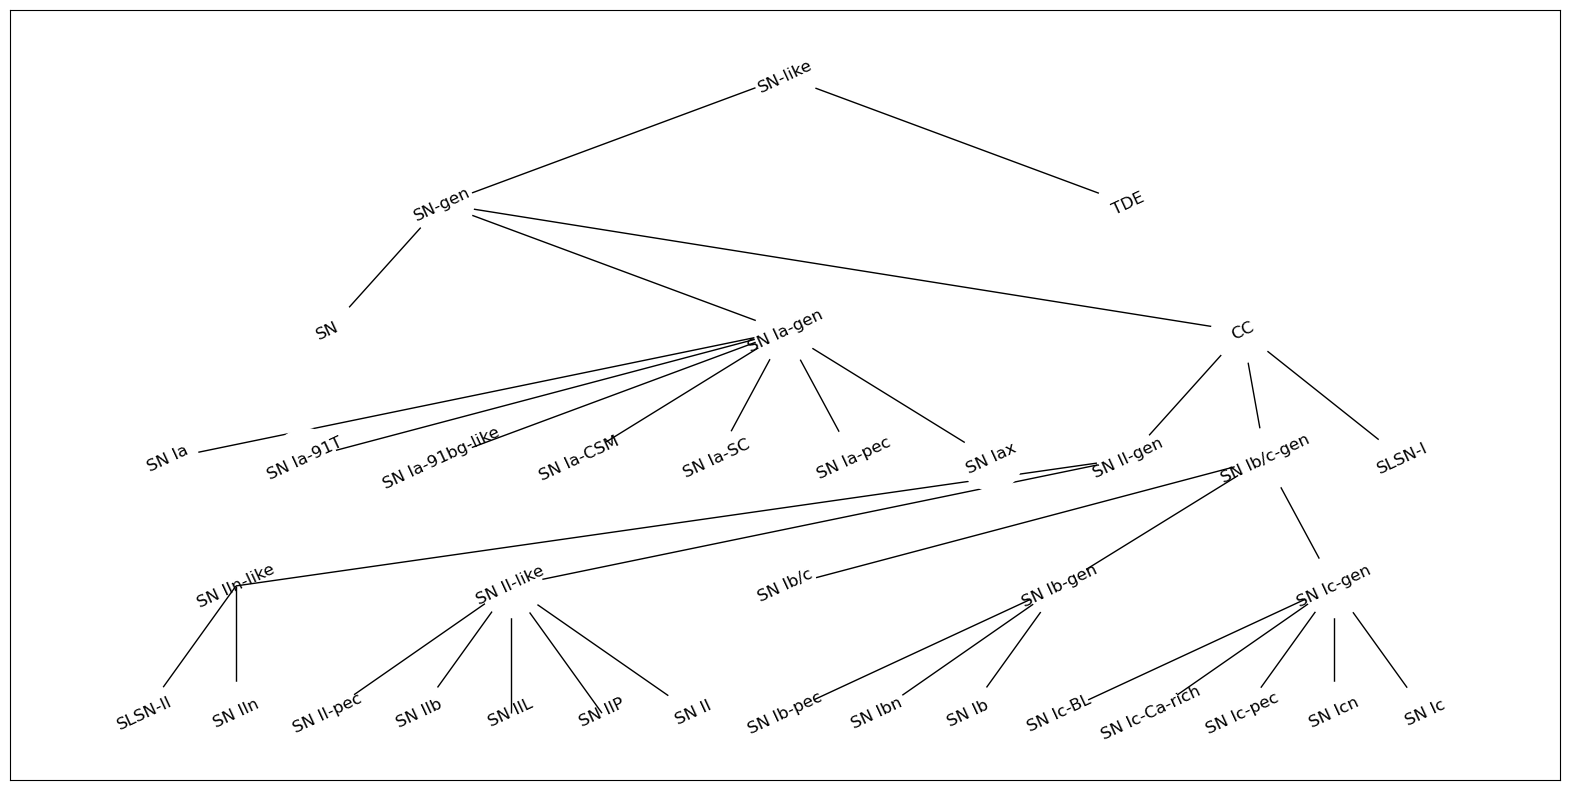

In [159]:
# Encode positions of graph - purely for drawing purposes
pos = hierarchy_pos(G, 'SN-like')
#print(pos)

fig = plt.figure(1, figsize=(20,10))
nx.draw_networkx(G, pos=pos, nodelist=vertices, node_color='white', with_labels=False, node_size=2000, arrows=False)
text = nx.draw_networkx_labels(G, pos)

#Uncomment if need to rotate the labels for a more advanced label system.
for _, t in text.items():
     t.set_rotation(25) 

plt.show()

### Find the shortest paths between root and all other nodes.

In [160]:
def short_paths(graph, vertices, root):
    """
    Builds a list of shortest paths from root to node from our tree.
    """
    paths = []
    for node in vertices:
        paths.append(nx.shortest_path(graph, root, node))
    return paths

In [161]:
all_paths = short_paths(G, vertices, 'SN-like')
all_paths

[['SN-like', 'SN-gen', 'CC', 'SLSN-I'],
 ['SN-like', 'SN-gen', 'CC', 'SN II-gen', 'SN IIn-like', 'SLSN-II'],
 ['SN-like', 'SN-gen', 'SN'],
 ['SN-like', 'SN-gen', 'CC', 'SN II-gen', 'SN II-like', 'SN II'],
 ['SN-like', 'SN-gen', 'CC', 'SN II-gen', 'SN II-like', 'SN II-pec'],
 ['SN-like', 'SN-gen', 'CC', 'SN II-gen', 'SN II-like', 'SN IIb'],
 ['SN-like', 'SN-gen', 'CC', 'SN II-gen', 'SN IIn-like', 'SN IIn'],
 ['SN-like', 'SN-gen', 'SN Ia-gen', 'SN Ia'],
 ['SN-like', 'SN-gen', 'SN Ia-gen', 'SN Ia-91T'],
 ['SN-like', 'SN-gen', 'SN Ia-gen', 'SN Ia-91bg-like'],
 ['SN-like', 'SN-gen', 'SN Ia-gen', 'SN Ia-CSM'],
 ['SN-like', 'SN-gen', 'SN Ia-gen', 'SN Ia-SC'],
 ['SN-like', 'SN-gen', 'SN Ia-gen', 'SN Ia-pec'],
 ['SN-like', 'SN-gen', 'SN Ia-gen', 'SN Iax'],
 ['SN-like', 'SN-gen', 'CC', 'SN Ib/c-gen', 'SN Ib-gen', 'SN Ib'],
 ['SN-like', 'SN-gen', 'CC', 'SN Ib/c-gen', 'SN Ib-gen', 'SN Ib-pec'],
 ['SN-like', 'SN-gen', 'CC', 'SN Ib/c-gen', 'SN Ib/c'],
 ['SN-like', 'SN-gen', 'CC', 'SN Ib/c-gen', 'SN 

### Function to calculate the class weights.

Copied from hxetda.py from https://github.com/VTDA-Group/hxe-for-tda/blob/main/hxetda/hxetda.py

In [ ]:
def calc_class_weights(counts, all_paths):
    """Generates the class weights based on the data.
    
    Calculates W(c^(h)) = N_all / (N_{labels} * N_c) where:
    N_all = total number of events in the dataset
    N_labels = the number of unique classes
    N_c = the number of events of class c

    Parameters
    ----------
    counts : panda dataframe
        A pandas dataframe of labels and counts from the CSV file.
    
    all_paths : str list list
        List of all the shortest paths between root and and a given node
        in the tree. This is found using Dijkstra's.

    Returns
    -------
    class_weight_dict : str -> float
        Contains weights of each label in the dataset (due to
        unbalanced data).
    """

    # Get the names and counts of the unique classes within the data set
    names_list = counts.index.tolist()
    counts_list = counts.values.tolist()

    # Generates class weight dictionary
    class_weight_dict = {}

    # We need to include everything in the hierarchy under a given label in the count of class c
    for label in names_list:
        count_for_ulabel = 0
        print("---label: ", label, "----")

        for label2 in names_list:
            # this index in vertices corresponds to the path that terminates in label2 in all_paths
            g_ind = vertices.index(label2)
            if label in all_paths[g_ind]:
                count_for_ulabel += counts_list[names_list.index(label2)]
        
        class_weight_dict[label] = (sum(counts_list)/(len(names_list) * count_for_ulabel))
    return class_weight_dict

In [163]:
class_weights = calc_class_weights(counts, all_paths)
class_weights

---label:  SN Ia ----
label2:  SN Ia
g_ind:  7
all_paths:  ['SN-like', 'SN-gen', 'SN Ia-gen', 'SN Ia']
True, add 11081 to 0

label2:  SN II
g_ind:  3
all_paths:  ['SN-like', 'SN-gen', 'CC', 'SN II-gen', 'SN II-like', 'SN II']

label2:  SN IIn
g_ind:  6
all_paths:  ['SN-like', 'SN-gen', 'CC', 'SN II-gen', 'SN IIn-like', 'SN IIn']

label2:  SN Ic
g_ind:  18
all_paths:  ['SN-like', 'SN-gen', 'CC', 'SN Ib/c-gen', 'SN Ic-gen', 'SN Ic']

label2:  SN Ib
g_ind:  14
all_paths:  ['SN-like', 'SN-gen', 'CC', 'SN Ib/c-gen', 'SN Ib-gen', 'SN Ib']

label2:  SN IIb
g_ind:  5
all_paths:  ['SN-like', 'SN-gen', 'CC', 'SN II-gen', 'SN II-like', 'SN IIb']

label2:  SLSN-I
g_ind:  0
all_paths:  ['SN-like', 'SN-gen', 'CC', 'SLSN-I']

label2:  SN Ic-BL
g_ind:  19
all_paths:  ['SN-like', 'SN-gen', 'CC', 'SN Ib/c-gen', 'SN Ic-gen', 'SN Ic-BL']

label2:  SN Ia-91bg-like
g_ind:  9
all_paths:  ['SN-like', 'SN-gen', 'SN Ia-gen', 'SN Ia-91bg-like']

label2:  TDE
g_ind:  23
all_paths:  ['SN-like', 'TDE']

label2:  SL

{'SN Ia': 0.06672765011362611,
 'SN II': 0.2781825022231343,
 'SN IIn': 1.5436515467830707,
 'SN Ic': 2.014738667327223,
 'SN Ib': 2.46469696969697,
 'SN IIb': 2.865926708949965,
 'SLSN-I': 3.996805896805897,
 'SN Ic-BL': 4.650371640937679,
 'SN Ia-91bg-like': 4.801357733175915,
 'TDE': 6.975557461406518,
 'SLSN-II': 7.178729037952339,
 'SN Ia-pec': 7.70217803030303,
 'SN': 8.802489177489177,
 'SN Ib/c': 9.60271546635183,
 'SN Ibn': 11.0359565807327,
 'SN Ia-CSM': 19.984029484029485,
 'SN Ib-pec': 46.21306818181818,
 'SN II-pec': 49.2939393939394,
 'SN Ia-SC': 52.814935064935064,
 'SN Icn': 105.62987012987013,
 'SN Ic-pec': 246.46969696969697,
 'SN Ic-Ca-rich': 739.4090909090909}

### Translate into Copy-able Format for Config.yaml

This writes to class_Weight_config_copy.yaml in this folder. You need to copy
the contents of this file to the correct config.yaml file for use.

In [165]:
def reformat(class_w_dict):
    class_w = {'class-weights' : class_w_dict}
    with open('class_weight_config_copy.yaml', 'w') as f:
        yaml.dump(class_w, f)

In [166]:
reformat(class_weights)

Sanity check to make sure that the dictionary is written to the config file format
correctly.

In [167]:
import yaml

# Open and load the YAML file
with open('class_weight_config_copy.yaml', 'r') as f:
    data = yaml.safe_load(f)

# Now `data` is a Python dictionary
print(data)

{'class-weights': {'SLSN-I': 3.996805896805897, 'SLSN-II': 7.178729037952339, 'SN': 8.802489177489177, 'SN II': 0.2781825022231343, 'SN II-pec': 49.2939393939394, 'SN IIb': 2.865926708949965, 'SN IIn': 1.5436515467830707, 'SN Ia': 0.06672765011362611, 'SN Ia-91bg-like': 4.801357733175915, 'SN Ia-CSM': 19.984029484029485, 'SN Ia-SC': 52.814935064935064, 'SN Ia-pec': 7.70217803030303, 'SN Ib': 2.46469696969697, 'SN Ib-pec': 46.21306818181818, 'SN Ib/c': 9.60271546635183, 'SN Ibn': 11.0359565807327, 'SN Ic': 2.014738667327223, 'SN Ic-BL': 4.650371640937679, 'SN Ic-Ca-rich': 739.4090909090909, 'SN Ic-pec': 246.46969696969697, 'SN Icn': 105.62987012987013, 'TDE': 6.975557461406518}}


Sanity check to make sure weights equally weight each class (without double counting).
Note, we assume that all data labels/classes should be leaves within the taxonomy.

In [173]:
# count_dict = {}
# for i in class_weights.keys():
#     names_list = counts.index.tolist()
#     counts_list = counts.values.tolist()
#     count_for_ulabel = 0
#     for label in names_list:
#         g_ind = vertices.index(label)
#         if i in all_paths[g_ind]:
#             count_for_ulabel += counts_list[names_list.index(label)]
        
#     print(i, ":", class_weights[i]*count_for_ulabel)
count_dict = {}
for i in class_weights.keys():    
    print(i, ":", class_weights[i]*counts_list[names_list.index(i)])


SN Ia : 739.4090909090909
SN II : 739.4090909090909
SN IIn : 739.4090909090909
SN Ic : 739.4090909090909
SN Ib : 739.409090909091
SN IIb : 739.409090909091
SLSN-I : 739.4090909090909
SN Ic-BL : 739.4090909090909
SN Ia-91bg-like : 739.4090909090909
TDE : 739.4090909090909
SLSN-II : 739.4090909090909
SN Ia-pec : 739.4090909090909
SN : 739.4090909090909
SN Ib/c : 739.4090909090909
SN Ibn : 739.4090909090909
SN Ia-CSM : 739.4090909090909
SN Ib-pec : 739.4090909090909
SN II-pec : 739.409090909091
SN Ia-SC : 739.4090909090909
SN Icn : 739.4090909090909
SN Ic-pec : 739.4090909090909
SN Ic-Ca-rich : 739.4090909090909
